# Using Machine Learning with MNE

## Imports

In [1]:
from Data import download_EEGBCI 

subject = [1,2,3]
total_subjects = list(range(1, 110))
runs = list(range(1, 15))

download_EEGBCI(2, [1,2,3], './EEGData', False)

Data downloaded!


In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import torch
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

## Data Import and Configurations

In [2]:
# DEfine the time window for epochs around the events
t_min, t_max = -1., 4.

# Dictionary that maps event names to their corresponding event codes.
# Event codes are numeric identifiers that are used to label different type of events or triggers in EEG/MEG data.
event_id = {'hands': 2, 'feet': 3}

# This is the subject we choose to study. Can be in the range of 1-109 (inclusive)
subject = 1

# This is the run we choose to study. Can be in the range of 1-14 (inclusive)
runs = [6, 10, 14]  # motor imagery: hands vs feet

| run | task |
| --- | --- |
| 1 | baseline, eyes open |
| 2 | baseline, eyes closed |
| 3, 7, 11 | Motor execution: left vs right hand | 
| 4, 8, 12 | Motor imagery: left vs right hand |
| 5, 9, 13 | Motor execution: hands vs feet |
| 6, 10, 14 | Motor imagery: hands vs feet |

In [4]:
# Loads in the subject and runs you're interested in
raw_fnames = mne.datasets.eegbci.load_data(subject, runs, './', verbose=False)

# Loads in the data file then reads and concatenates the data into the `raw` object
raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])

# Set channel names in the EEG data
mne.datasets.eegbci.standardize(raw)

# This creates an info object that represents the 10/05 electrode positions 
montage = mne.channels.make_standard_montage("standard_1005")

# Attaches the montage to the raw data
raw.set_montage(montage)

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [5]:
# This applies a bandpass filter (finite impulse response) to the data and avoids filtering data near the edge
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

# This line extracts information from annotations present in the raw data.
# Annotations are labels attached to specific points in the data and usually represent events or important time segments.
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# This line selects specific channel types from the raw data
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Used Annotations descriptions: ['T1', 'T2']


In [6]:
epochs = mne.Epochs(
    raw, # Datase
    events, # Events
    event_id, # Event ID
    t_min, # Start time
    t_max, # End time
    proj=True, # Apply SSP projection vectors
    picks=picks, # Channels to include
    baseline=None, # Baseline interval
    preload=True, # Load data into memory
)

# This creates a new epochs object by copying the original epochs object and cropping the time interval from 1 to 2 seconds.
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)

# This creates a numpy array that contains the labels for each epoch. 
# The labels are stored in the last column of the events array. 
# The labels are stored as integers, but we want them to be 0 and 1. 
# We can subtract 2 from the labels to get the desired values.
labels = epochs.events[:, -1] - 2

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


Using matplotlib as 2D backend.


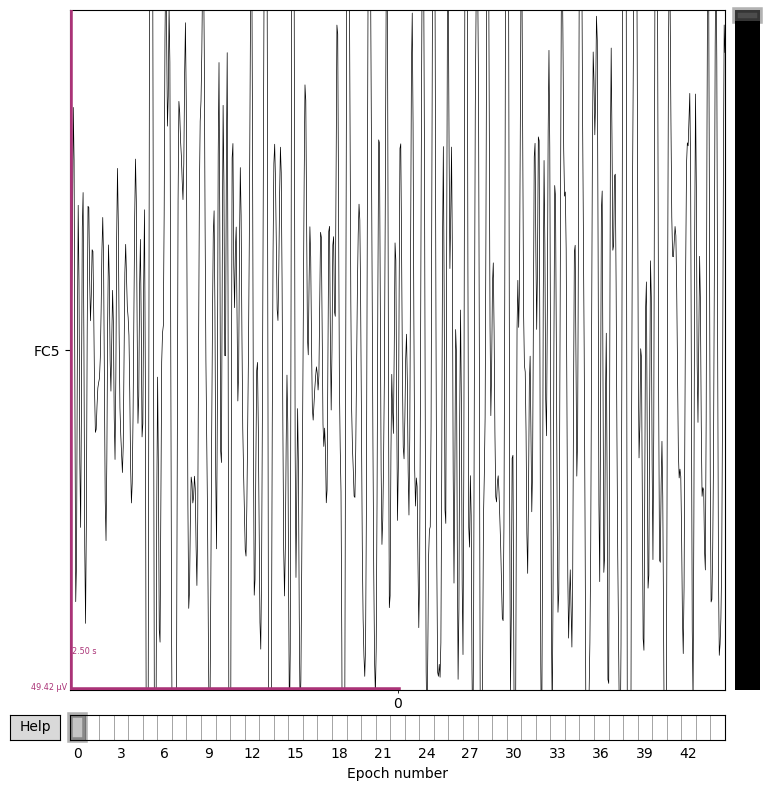

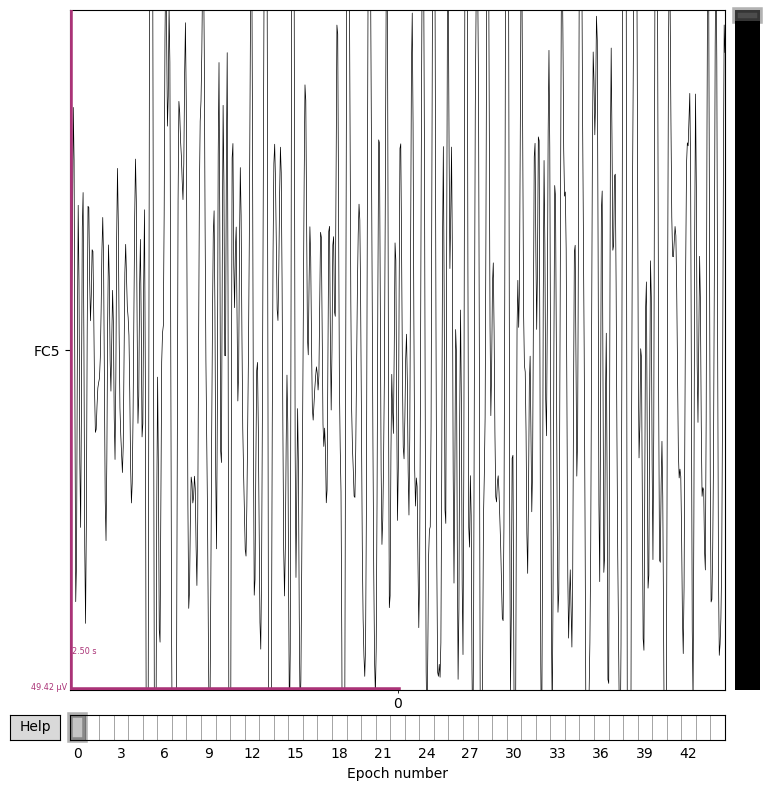

In [7]:
epochs.plot(n_channels=1, n_epochs=1, scalings='auto')

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

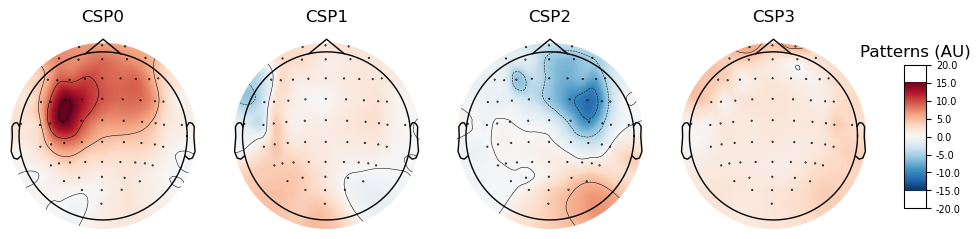

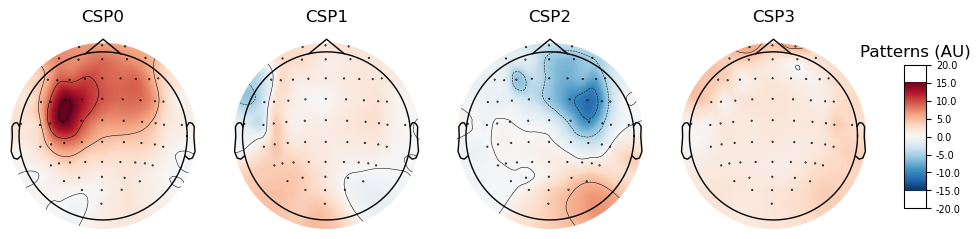

In [8]:
# Define a monte-carlo cross-validation generator (reduce variance):
# Keeps track of an empty list called scores for the cross-validation procedure
scores = []
# This extracts the data as a numpy array from the MNE object
epochs_data = epochs.get_data()
# This extracts the data from the epochs_train object
epochs_data_train = epochs_train.get_data()
# This line creates a cross-validation (CV) generator using the ShuffleSplit method
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
# This line creates the actual cross-validation splits using the splits method of the CV generator
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# This code above sets up a classification pipeline that includes CSP for feature extraction and LDA as the classifier
# It then performs cross-validation using the pipeline and prints the average classification accuracy and chance level of classification accuracy.
# This code aims to evaluate the performance of the classifier on the given EEG data and the corresponding labels using cross-validation

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
 

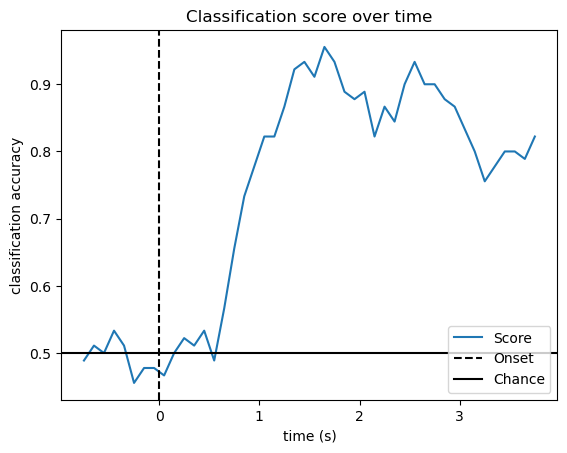

In [9]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()